# 確率過程

強化学習では時刻にそって確率的な方策や確率的な環境に従ってエージェントが行動していきます。

これは数学的には``確率過程``として定義することができます。

---

**定義：確率過程**

時間域を$T$とする。例えば $T=\mathbb{R_+}$ならこれは連続時間で、$T=\mathbb{Z_+}$なら離散時間である。
任意の $t \in T$について、$X_t: \Omega \to S$ が可測であるとき、$X=(X_t)_{t\in T}$ を確率過程と呼ぶ。
ここで、Sは 状態空間 (例えば $S=\mathbb{R}, \mathcal{B}_S = \mathcal{B}(\mathbb{R})$ は連続状態）である。

---

今回は、その中でも重要なPoisson過程とGauss過程について学びます。

# Poisson Random Measure と Poisson過程

Poisson Random MeasureはPoisson過程を定義する上で必要になる測度であり、単体としても重要な測度です。
Poisson Random Measure は``空間上でランダムに発生する事象の件数``のモデリングなどに用いられます。

---

**定義：Poisson Random Measure**

確率変数の族 $X = (X(A))_{A \in \mathcal{B}(\mathbb{R}^d)}$ が次を満たすとき、$X$を平均測度 $\mu$ の Poisson Random Measureという。

1. a.s. $\omega \in \Omega$ において、$X(A)=X(A, \omega)$が$A$の関数として $\sigma$-有限な非負測度になっている。
2. 任意の$E \in \mathcal{B}(\mathbb{R}^d)$ に対し、$X(E)$は平均$\mu(E)$のPoisson分布に従う。
3. 任意の互いに疎な$E_1, \dots, E_n \in \mathcal{B}(\mathbb{R}^d)$ に対し、$X(E_i)$は独立。

---

例えば、日本で起きる交通事故のモデリングを考えてみます。

日本全体で生じる``交通事故の件数`` $Z$ をPoisson分布からサンプルして、その $Z$ 件の交通事故を``発生しやすい場所``の度合いを測る確率測度 $\nu$ に従って各地方に散りばめれば良さそうです。

実際にPythonでPoisson Random Measureを構築してみましょう。

In [34]:
import numpy as np
import matplotlib.pyplot as plt

japan_mean_measure = 110

def area_measure(area: frozenset):
    return {
        frozenset([]): 0,
        frozenset(["東北"]): 10,
        frozenset(["関東"]): 20,
        frozenset(["近畿"]): 80,
        frozenset(["東北", "近畿"]): 90,
        frozenset(["東北", "関東"]): 30,
        frozenset(["関東", "近畿"]): 100,
        frozenset(["東北", "関東", "近畿"]): 110,
    }[area]


def poisson_random_measure():
    # Z個の事故を発生させます
    Z = np.random.poisson(japan_mean_measure)

    # Z個の事故をarea_probabilityに従って各地方に割り当てます
    # 1: 東北, 2: 関東, 3: 近畿　とします
    keys = [1, 2, 3]
    probs = [
        area_measure(frozenset(["東北"])) / japan_mean_measure, 
        area_measure(frozenset(["関東"])) / japan_mean_measure, 
        area_measure(frozenset(["近畿"])) / japan_mean_measure, 
    ]
    accidents = np.random.choice(keys, size=Z, replace=True, p=probs)
    _, num_accidents = np.unique(accidents, return_counts=True)

    # 測度を構築します
    prm = {
        frozenset([]): 0,
        frozenset(["東北"]): num_accidents[0],
        frozenset(["関東"]): num_accidents[1],
        frozenset(["近畿"]): num_accidents[2],
        frozenset(["東北", "近畿"]): num_accidents[0] + num_accidents[2],
        frozenset(["東北", "関東"]): num_accidents[0] + num_accidents[1],
        frozenset(["関東", "近畿"]): num_accidents[1] + num_accidents[2],
        frozenset(["東北", "関東", "近畿"]): np.sum(num_accidents),
    }
    return prm

poisson_random_measure()

{frozenset(): 0,
 frozenset({'東北'}): 9,
 frozenset({'関東'}): 17,
 frozenset({'近畿'}): 66,
 frozenset({'東北', '近畿'}): 75,
 frozenset({'東北', '関東'}): 26,
 frozenset({'近畿', '関東'}): 83,
 frozenset({'東北', '近畿', '関東'}): 92}

``poisson_random_measure``を実行すると、ランダムな測度が返ってくることがわかります。なのでPoisson random measureと呼ばれます。これが先程のPoisson Random Measureの定義を満たしていることを確認しましょう (宿題)。

ようやくPoisson過程の定義ができます。

---

**定義：Poisson過程**

$(\mathbb{R}, \mathcal{B}({\mathbb{R}}))$上の Poisson Random Measure $Y=(Y(A))_{A\in \mathcal{B}(\mathbb{R})}$ を考えて、$X_t(\omega)=Y([0, t])(\omega)$ とする。
このとき、$(X_t)_{t\geq0}$ をPoisson過程と呼ぶ。

特に $\mu([a, b])=\lambda (b - a)$のときに$X$を強度$\lambda$のPoisson過程と呼び、これは一様強度である。

---

Poisson過程は例えば来客数のモデリングなどに使用できます。
試しに$[t, t+10)$について、一様強度 $\lambda$ のPoisson過程を考えてみます。

まず、時刻 $[t, t+10)$ の期待値 $10 \lambda$ に従って、来客数 $Z$ をランダムにサンプルします。
これを各時刻間 $[t, t+1), [t+1, t+2), \dots, [t+9, t+10)$ の期待値に従って散りばめます。今回は全て一様強度のため、一様にばらまきます。

Text(0, 0.5, "$X_t (\\omega)$ for some $\\omega$ due to 'np.random.poisson'")

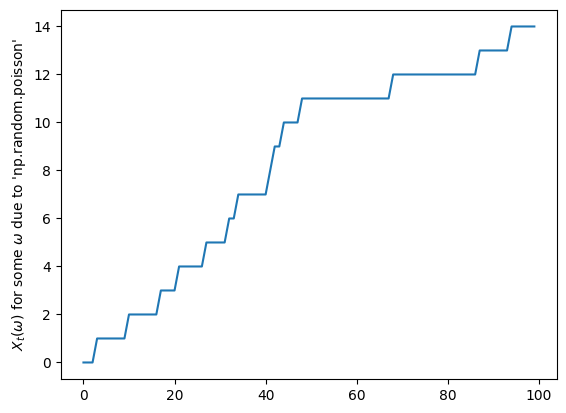

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

lamb = 0.2  # 強度
t = np.arange(0, 100, 1)  # 時刻 [0, 100]
poisson_process = np.zeros(100)

Z = np.random.poisson(lamb * 100)
Y_t = np.random.randint(0, 99, Z)  # Z個の来客を一様にばらまく
for y in Y_t:
    poisson_process[y] += 1
poisson_process = np.cumsum(poisson_process)

plt.plot(t, poisson_process)
plt.ylabel(r"$X_t (\omega)$ for some $\omega$ due to 'np.random.poisson'")

ちなみに、ジャンプの高さについてもランダムに決まるPoisson過程は``Compound ポアソン過程``と呼ばれます。